# Classifier Training Notebook
This notebook trains my NFL classifier. For each bbox, the classifier takes a 96x96 crop around the bbox and the 4 previous frames by step 2, and 4 following frames step 2, i.e. frames -8, -6, -4, -2, 0, ,2 ,4 ,6, 8. We can then build a classifier that uses any of these 9 frame crops.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

VER = 61

In [2]:
import pandas as pd, numpy as np
import albumentations as albu
import tensorflow as tf
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn
import cv2

In [3]:
#strategy = tf.distribute.MirroredStrategy()

In [4]:
#tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
#print('Mixed precision enabled')

# Load Labels

In [5]:
# FULL LABELS
df = pd.read_csv('/raid/Kaggle/NFL/train_labels.csv')
print( df.shape )

# TRAIN ON ALL FRAMES INCLUDING IMPACT AND THEN 30K ADDITION BBOX FROM NON-IMPACT FRAMES
keep = df.groupby(['gameKey','playID','view','frame']).impact.transform('sum')>0
idx = df.loc[~keep].sample(30_838,random_state=42).index
df = df.loc[(df.index.isin(idx))| keep ]

#df = df.loc[(df.impact==1)&(df.confidence>1)&(df.visibility>0)]

print( df.shape )
df.head()

(983885, 14)
(60000, 14)


gameKey  playID     view                     video  frame label  left  \
12    57583      82  Endzone  57583_000082_Endzone.mp4      1   H90   245   
14    57583      82  Endzone  57583_000082_Endzone.mp4      1   V68   551   
18    57583      82  Endzone  57583_000082_Endzone.mp4      1   H27  1219   
31    57583      82  Endzone  57583_000082_Endzone.mp4      2   H50   518   
43    57583      82  Endzone  57583_000082_Endzone.mp4      3   V34   550   

    width  top  height  impact impactType  confidence  visibility  
12     21  327      29     NaN        NaN         NaN         NaN  
14      8  333      12     NaN        NaN         NaN         NaN  
18     21  176      29     NaN        NaN         NaN         NaN  
31     21  211      28     NaN        NaN         NaN         NaN  
43     23  462      19     NaN        NaN         NaN         NaN

In [6]:
# REZA VALIDATION
valid_videos = ['57995_000109_Endzone.mp4', '57995_000109_Sideline.mp4',
       '57906_000718_Endzone.mp4', '57906_000718_Sideline.mp4',
       '58102_002798_Endzone.mp4', '58102_002798_Sideline.mp4',
       '57992_000350_Endzone.mp4', '57992_000350_Sideline.mp4',
       '57992_000301_Endzone.mp4', '57992_000301_Sideline.mp4',
       '57680_002206_Endzone.mp4', '57680_002206_Sideline.mp4',
       '58094_002819_Endzone.mp4', '58094_002819_Sideline.mp4',
       '57787_003413_Endzone.mp4', '57787_003413_Sideline.mp4',
       '57786_003085_Endzone.mp4', '57786_003085_Sideline.mp4',
       '58103_003494_Endzone.mp4', '58103_003494_Sideline.mp4',
       '57915_003093_Endzone.mp4', '57915_003093_Sideline.mp4',
       '57700_001264_Endzone.mp4', '57700_001264_Sideline.mp4']

# JIN/THEO VALIDATION
valid_videos = ['57586_000540_Endzone.mp4', '57586_000540_Sideline.mp4',
       '57586_001934_Endzone.mp4', '57586_001934_Sideline.mp4',
       '57586_004152_Endzone.mp4', '57586_004152_Sideline.mp4',
       '58106_002918_Endzone.mp4', '58106_002918_Sideline.mp4',
       '57778_004244_Endzone.mp4', '57778_004244_Sideline.mp4',
       '57781_000252_Endzone.mp4', '57781_000252_Sideline.mp4',
       '57783_003374_Endzone.mp4', '57783_003374_Sideline.mp4',
       '57784_001741_Endzone.mp4', '57784_001741_Sideline.mp4',
       '57910_001164_Endzone.mp4', '57910_001164_Sideline.mp4',
       '58000_001306_Endzone.mp4', '58000_001306_Sideline.mp4',
       '58098_001193_Endzone.mp4', '58098_001193_Sideline.mp4',
       '58107_004362_Endzone.mp4', '58107_004362_Sideline.mp4']

df['v'] = 0
df.loc[df.video.isin(valid_videos),'v'] = 1
df.v.sum()

12180

In [7]:
%%time
df['target'] = 0
df['i'] = df.index #needed to locate image on disk
df['fmax'] = df.groupby('video').frame.transform('max')
df = df.loc[(df.frame>8)&(df.fmax-df.frame>8)].reset_index(drop=True)
df.loc[(df.impact==1)&(df.confidence>1)&(df.visibility>0),'target'] = 1

def make_name(x):
    name = '%i_%.6i_%s_%i_%.6i.png'%(x.gameKey,x.playID,x['view'],x.frame,x.i)
    return name
df['image'] = df.apply(make_name,axis=1)
print( df.shape )

(58720, 19)
CPU times: user 2.49 s, sys: 14.4 ms, total: 2.51 s
Wall time: 2.51 s


In [8]:
df.target.value_counts()

0    56832
1     1888
Name: target, dtype: int64

# Data Loader

In [9]:
PATH = '/raid/Kaggle/NFL/crops_v4/'

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=64, shuffle=False, augment=False): 

        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int((len(self.df) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes, index)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.df) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes, index):
        'Generates data containing batch_size samples'        

        X = np.zeros((len(indexes),288,288,3),dtype='uint8')        
        y = self.df.loc[indexes,'target'].values
        names = self.df.loc[indexes,'image'].values

        for i,n in enumerate(names):
            img = cv2.imread(PATH+n)
            imgs = {'image' : img[0:128,0:128,:]}
            for k in range(1,9):
                rw = k//3; cl = k%3   
                imgs['image%i'%k] = img[128*rw:128*(rw+1),128*cl:128*(cl+1),:]
            
            if self.augment:
                imgs = self.__random_transform(imgs)
            else:
                imgs = self.__random_transform2(imgs)
                
            X[i,:96,:96,:] = imgs['image']
            for k in range(1,9):
                rw = k//3; cl = k%3   
                X[i,96*rw:96*(rw+1),96*cl:96*(cl+1),:] = imgs['image%i'%k] 
                
        return X[:,:,:,::-1], y
 
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            albu.ShiftScaleRotate(rotate_limit=15,scale_limit=0.15,shift_limit=0,border_mode=4,p=0.5),
            albu.CoarseDropout(max_holes=16,max_height=12,max_width=12,fill_value=0,p=0.5),
            #albu.Blur(blur_limit=5, always_apply=False, p=0.1),
            albu.ChannelDropout (channel_drop_range=(1, 1), fill_value=0.2, always_apply=False, p=0.05),
            albu.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.25),
            albu.MotionBlur(blur_limit=24,p=0.1),
            #albu.RandomFog (fog_coef_lower=0.15, fog_coef_upper=0.25, alpha_coef=0.3, always_apply=False, p=0.0),
            albu.RandomRain (slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200),
                             blur_value=2, brightness_coefficient=0.7, rain_type=None, always_apply=False, p=0.1),
            albu.RandomShadow (shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, 
                          shadow_dimension=5, always_apply=False, p=0.1),
            #albu.RandomSnow (snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=1.5, always_apply=False, p=0.0),
            albu.RandomSunFlare (flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1, num_flare_circles_lower=6, 
                            num_flare_circles_upper=10, src_radius=100, src_color=(255, 255, 255), always_apply=False, p=0.1),
            albu.RandomCrop(96,96,p=1.0)],
            additional_targets = {'image%i'%k : 'image' for k in range(1,9)}
        )
        return composition(**img)
    
    def __random_transform2(self, img):
        composition = albu.Compose([
            albu.CenterCrop(96,96,p=1.0)],
            additional_targets = {'image%i'%k : 'image' for k in range(1,9)}
        )
        return composition(**img)

# Display Dataloader Examples

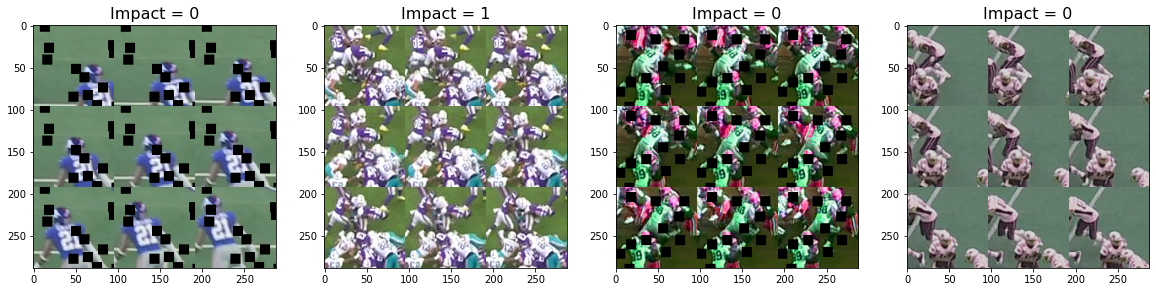

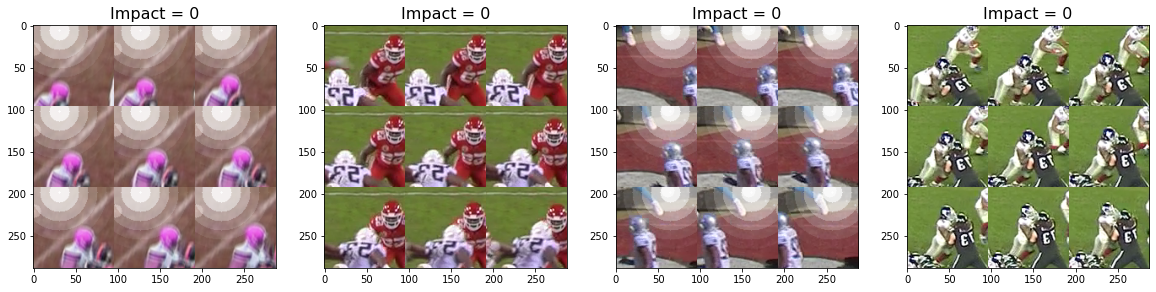

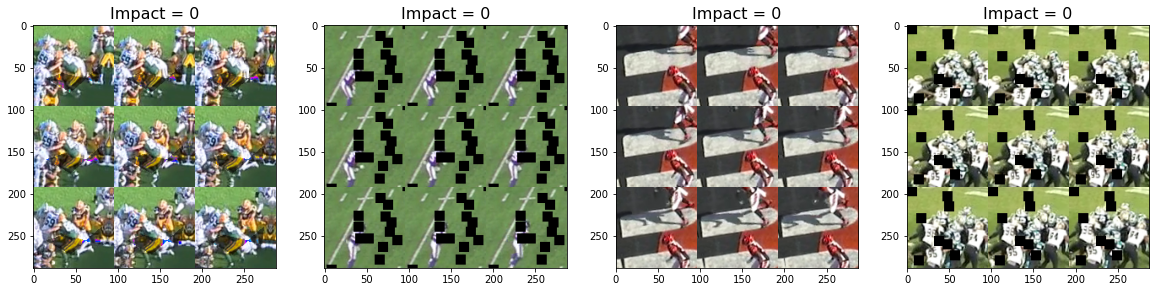

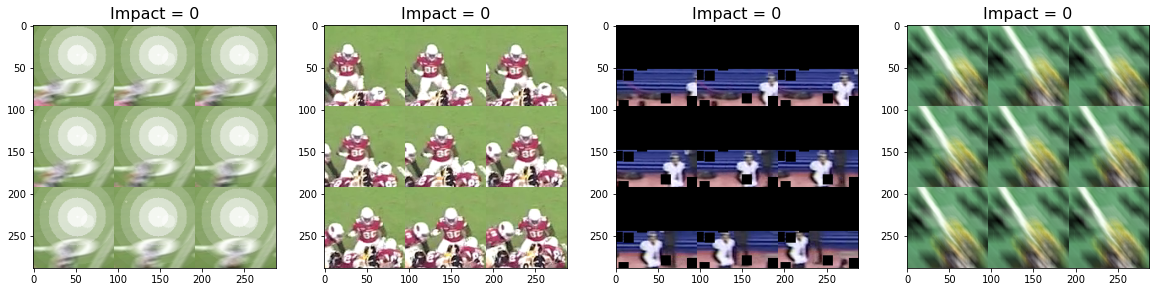

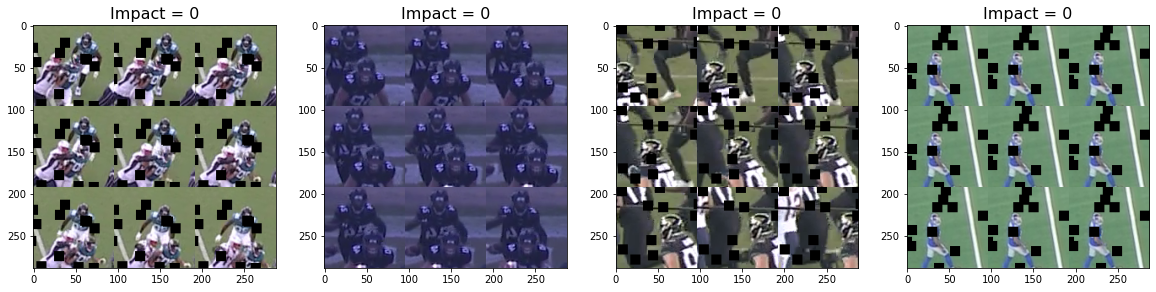

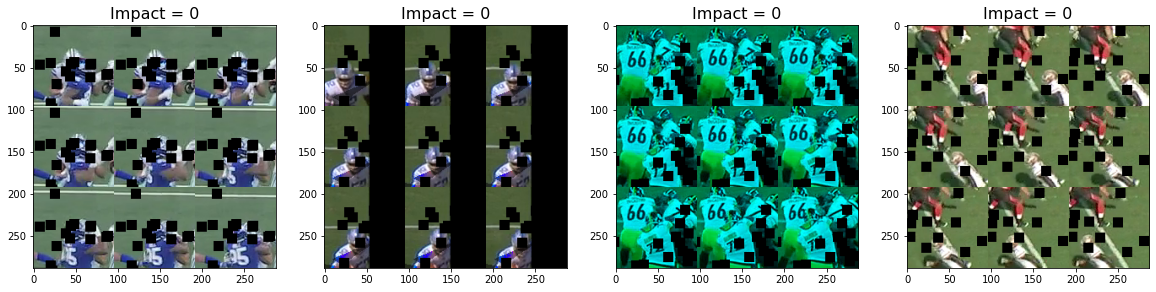

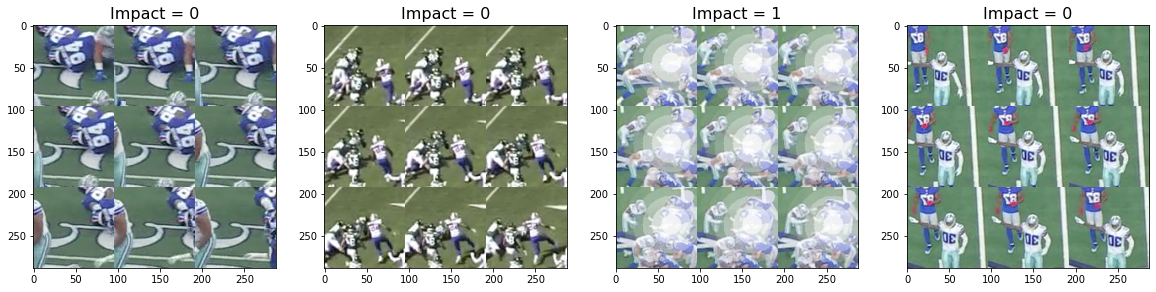

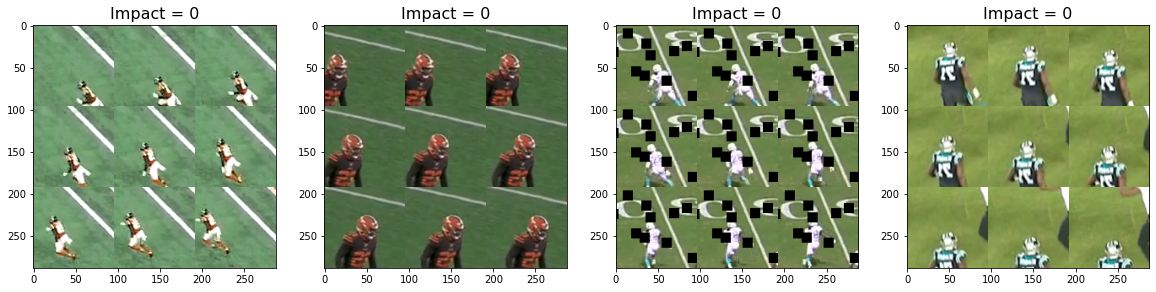

In [11]:
# DISPLAY EXAMPLES OF DATALOADER
train_gen = DataGenerator(df, augment=True, shuffle=True)

for i,b in enumerate(train_gen):

    plt.figure(figsize=(20,5))
    for k in range(4):
        plt.subplot(1,4,k+1)
        plt.imshow(b[0][k])
        t = b[1][k]
        plt.title('Impact = %i'%t,size=16)
    plt.show()
    if i>=7: break

# Video Crop Classifier

In [ ]:
def gru_layer(hidden_dim, dropout, rs=True):
    return tf.keras.layers.GRU(
        hidden_dim, dropout=dropout, return_sequences=rs, kernel_initializer='orthogonal')

In [12]:
def build_model(dimm=288):
    
    inp = tf.keras.Input(shape=(dimm,dimm,3))
    base_model = efn.EfficientNetB3(weights='imagenet',include_top=False, input_shape=(96,96,3)) 
    #base_model.load_weights('model.h5')
    #base_model.trainable = False

    embed=[]
    for k in range(9):
        if k not in [4]: continue
        rw = k//3; cl = k%3
        crop = inp[:,96*rw:96*(rw+1),96*cl:96*(cl+1),:]
        x = base_model(crop/255.)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)  
        #x = tf.expand_dims(x, axis=1)
        #embed.append(x)
           
    #x = tf.keras.layers.Concatenate(axis=1)(embed)
    #x = gru_layer(hidden_dim=128, dropout=0.1, rs=False)(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(lr=0.00005)
    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['AUC'])
        
    return model

# Train Model

In [13]:
#with strategy.scope():
#    model = build_model()

In [14]:
valid = df.loc[df.v==1]
train = df.loc[~df.index.isin(valid.index)].reset_index(drop=True)
valid.reset_index(drop=True,inplace=True)
train.shape, valid.shape

((46787, 19), (11933, 19))

In [15]:
train_gen = DataGenerator(train, shuffle=True, augment=True)
valid_gen = DataGenerator(valid)

In [16]:
sv = tf.keras.callbacks.ModelCheckpoint(
    'model_v%i.h5'%VER, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch'
)
rop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1,
    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
)

In [17]:
model = build_model()
model.fit(train_gen, epochs=100, validation_data=valid_gen, verbose=1, callbacks=[sv,rop],
          use_multiprocessing=True, workers=8)

Epoch 1/100
732/732 [==============================] - ETA: 0s - loss: 0.1883 - auc: 0.6216WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_loss improved from inf to 0.12546, saving model to model_v59.h5
732/732 [==============================] - 106s 145ms/step - loss: 0.1883 - auc: 0.6216 - val_loss: 0.1255 - val_auc: 0.7749
Epoch 2/100
732/732 [==============================] - ETA: 0s - loss: 0.1296 - auc: 0.7584WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_loss improved from 0.12546 to 0.11342, saving model to model_v59.h5
732/732 [==============================] - 100s 136ms/step - loss: 0.1296 - auc: 0.7584 - val_loss: 0.1134 - val_auc: 0.8377
Epoch 3/100
732/732 [==============================] - ETA: 0s - l

Process Keras_worker_ForkPoolWorker-377:
Process Keras_worker_ForkPoolWorker-380:
Process Keras_worker_ForkPoolWorker-383:
Process Keras_worker_ForkPoolWorker-384:
Process Keras_worker_ForkPoolWorker-381:
Traceback (most recent call last):
  File "/home/cdeotte/anaconda3/envs/rapids13/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cdeotte/anaconda3/envs/rapids13/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process Keras_worker_ForkPoolWorker-378:
  File "/home/cdeotte/anaconda3/envs/rapids13/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-382:
  File "/home/cdeotte/anaconda3/envs/rapids13/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  F

KeyboardInterrupt: 

Process Keras_worker_ForkPoolWorker-386:
Process Keras_worker_ForkPoolWorker-385:
Process Keras_worker_ForkPoolWorker-387:
Process Keras_worker_ForkPoolWorker-389:
Process Keras_worker_ForkPoolWorker-391:
Process Keras_worker_ForkPoolWorker-392:
Process Keras_worker_ForkPoolWorker-390:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-388:
  File "/home/cdeotte/anaconda3/envs/rapids13/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/cdeotte/anaconda3/envs/rapids13/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cdeotte/anaconda3/envs/rapids13/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    tas